In [1]:
import os
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from MachineLearningUtils import plot_confustion_matrix, error_rate
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score

# import data

In [2]:
df_train = pd.read_pickle('../data/df_train.pkl.gzip', compression='gzip')
df_test = pd.read_pickle('../data/df_test.pkl.gzip', compression='gzip')

In [3]:
df = pd.concat([df_train, df_test])

In [4]:
df.shape

(15386, 19)

# Feature Engineering

## Drop unnecessary columns

In [5]:
# df.drop(['receiver_latitude', 'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample', 'p_travel_sec',
#          's_arrival_sample', 'source_origin_time', 'source_latitude', 'source_longitude',
#          'source_depth_km','snr_db_E','snr_db_N','snr_db_Z'], axis=1, inplace=True)
df = df[['label' ,'target' ,'trace_id', 'E', 'N', 'Z']]

## Augment with average noise

In [6]:
df_noise = df.loc[df['target'] == 0,['E','N','Z']]


In [7]:
noise_E = np.mean(np.vstack(df_noise['E']), axis=0)
noise_N = np.mean(np.vstack(df_noise['N']), axis=0)
noise_Z = np.mean(np.vstack(df_noise['Z']), axis=0)

In [8]:
def random_sign():
    return 1 if np.random.random() >= 0.5 else -1

In [9]:
def augment_dataframe():
    E_noisy = df['E'].apply(lambda x: x+noise_E*np.random.uniform(0,0.1)*random_sign())
    N_noisy = df['N'].apply(lambda x: x+noise_N*np.random.uniform(0,0.1)*random_sign())
    Z_noisy = df['Z'].apply(lambda x: x+noise_Z*np.random.uniform(0,0.1)*random_sign())

    df_aug = pd.DataFrame({'label' : df['label'],'target' : df['target'],'trace_id' : df['trace_id'],
                           'E' : E_noisy, 'N' : N_noisy,'Z' : Z_noisy})
    return df_aug

In [10]:
df_augment = pd.concat([augment_dataframe() for ii in range(3) ])


In [11]:
df_augment = pd.concat([df, df_augment])


In [12]:
df_augment.reset_index(drop=True, inplace=True)


## rolling window

In [13]:
def moving_average(arr, lag):
    ret = np.cumsum(arr, dtype=float)
    ret[lag:] = ret[lag:] - ret[:-lag]
    return ret[lag - 1:] / lag

In [14]:
df_augment['E_MA250'] = df_augment['E'].apply(lambda x: moving_average(x,250))
df_augment['N_MA250'] = df_augment['N'].apply(lambda x: moving_average(x,250))
df_augment['Z_MA250'] = df_augment['Z'].apply(lambda x: moving_average(x,250))

df_augment['E_MA1000'] = df_augment['E'].apply(lambda x: moving_average(x,1000))
df_augment['N_MA1000'] = df_augment['N'].apply(lambda x: moving_average(x,1000))
df_augment['Z_MA1000'] = df_augment['Z'].apply(lambda x: moving_average(x,1000))

## Replace old df with new

In [15]:
print(df.shape)
df = df_augment
print(df.shape)

(15386, 6)
(61544, 12)


## Spectral Centroid

In [16]:
trace_list = ['E','N','Z']
trace_list_MA = ['E','N','Z', 'E_MA250', 'N_MA250', 'Z_MA250', 'E_MA1000', 'N_MA1000', 'Z_MA1000']

In [17]:
def spectral_centroid(x, samplerate=44100):
    magnitudes = np.abs(np.fft.rfft(x)) # magnitudes of positive frequencies
    length = len(x)
    freqs = np.abs(np.fft.fftfreq(length, 1.0/samplerate)[:length//2+1]) # positive frequencies
    return np.sum(magnitudes*freqs) / np.sum(magnitudes) # return weighted mean

In [18]:
for tl in trace_list_MA:
    df['spectral_centroid_{}'.format(tl)] = df[tl].apply(spectral_centroid)

## Degree of rectiliniarity (polarization)

In [19]:
from obspy.signal.polarization import flinn

/Users/christopher.zerafa/opt/anaconda3/lib/python3.7/site-packages/obspy/signal/headers.py:93: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ], align=True)


In [20]:
df['rect_azimuth'], df['rect_incidence'], df['rect_rectilinearity'],df['rect_planarity'] = zip(*df.apply(lambda x: flinn([x['Z'],x['N'],x['E']]), axis=1))

In [21]:
df['rect_azimuth_MA250'], df['rect_incidence_MA250'], df['rect_rectilinearity_MA250'],df['rect_planarity_MA250'] = zip(*df.apply(lambda x: flinn([x['Z_MA250'],x['N_MA250'],x['E_MA250']]), axis=1))

In [22]:
df['rect_azimuth_MA1000'], df['rect_incidence_MA1000'], df['rect_rectilinearity_MA1000'],df['rect_planarity_MA1000'] = zip(*df.apply(lambda x: flinn([x['Z_MA1000'],x['N_MA1000'],x['E_MA1000']]), axis=1))

## RMS of frequency amplitude

In [23]:
for tl in trace_list_MA:
    df['rms_freq_amp_{}'.format(tl)] = df[tl].apply( lambda x: np.sqrt(np.mean(np.square(np.real(np.fft.fft(x))))))

## Maximum power of frequency amplitude

In [24]:
from scipy import signal

In [25]:
for tl in trace_list_MA:
    df['max_power_freq_amp_{}'.format(tl)] = df[tl].apply(lambda x: np.sqrt(signal.periodogram(x, 100, 'flattop', scaling='spectrum')[1].max()))

## Dominant frequency

In [26]:
from obspy.signal.freqattributes import central_frequency_unwindowed

In [27]:
for tl in trace_list_MA:
    print('Processing {}'.format(tl))
    df['dominant_freq_{}'.format(tl)] = df[tl].apply(lambda x: central_frequency_unwindowed(x,fs=100))

Processing E
Processing N
Processing Z
Processing E_MA250
Processing N_MA250
Processing Z_MA250
Processing E_MA1000
Processing N_MA1000
Processing Z_MA1000


## Domint Peak in CWT

In [28]:
# for tl in trace_list:
#     print('Processing {}'.format(tl))
#     df['dominant_peak_cwt_{}'.format(tl)] = df[tl].apply(lambda x : signal.find_peaks_cwt(x, np.arange(1,10))[0])

## Waveform cross-correlation

In [29]:
from obspy.signal.cross_correlation import correlate as obspy_corr
def waveform_xc_properties(full_signal):
    window_step = round(full_signal.shape[0]/2)
    window_deep = full_signal[window_step:]
    window_shallow = full_signal[:window_step]
    xcor_deep = obspy_corr(full_signal, window_deep, window_step)
    xcor_shallow = obspy_corr(full_signal, window_shallow, window_step)
    return xcor_deep.max(), xcor_deep.mean(), xcor_shallow.max(), xcor_shallow.mean()

In [30]:
for tl in trace_list_MA:
    print('Processing {}'.format(tl))
    df['xcor_{}_deep_max'.format(tl)],df['xcor_{}_deep_mean'.format(tl)],df['xcor_{}_shallow_max'.format(tl)],df['xcor_{}_shallow_mean'.format(tl)]= zip(*df[tl].apply(lambda x : waveform_xc_properties(x)))

Processing E
Processing N
Processing Z
Processing E_MA250
Processing N_MA250
Processing Z_MA250
Processing E_MA1000
Processing N_MA1000
Processing Z_MA1000


## Envelope similarity

In [31]:
from scipy.signal import hilbert

def envelope(trace_Z):
    return np.sqrt((trace_Z**2) + (np.imag(hilbert(trace_Z))**2))

def envelope_similarity(trace_Z): 
    window_step = round(trace_Z.shape[0]/2)
    window_deep = trace_Z[window_step:]
    window_shallow = trace_Z[:window_step]
    env_sim_deep = np.sum(envelope(window_shallow)-envelope(window_deep))/envelope(window_shallow)
    env_sim_shallow = np.sum(envelope(window_deep)-envelope(window_shallow))/envelope(window_deep)
    return env_sim_deep.max(), env_sim_deep.mean(), env_sim_shallow.max(), env_sim_shallow.mean()

In [32]:
for tl in trace_list:
    print('Processing {}'.format(tl))
    df['{}_env_sim_deep_max'.format(tl)], df['{}_env_sim_deep_mean'.format(tl)], df['{}_env_sim_shallow_max'.format(tl)], df['{}_env_sim_shallow_mean'.format(tl)] = zip(*df[tl].apply(lambda x : envelope_similarity(x))) 

Processing E
Processing N
Processing Z


# Train-Test Split

In [33]:
# shuffles dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [34]:
X = df.drop(['label','target','trace_id','E','N','Z','E_MA250','N_MA250','Z_MA250','E_MA1000','N_MA1000','Z_MA1000'], axis=1)
y = df['target']

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2, random_state=0)

In [36]:
print('X_train {}'.format(X_train.shape))
print('X_test {}'.format(X_test.shape))
print('X_validation {}'.format(X_validation.shape))

X_train (39388, 96)
X_test (9847, 96)
X_validation (12309, 96)


## Model Column List

In [37]:
list(X_train.columns)

['spectral_centroid_E',
 'spectral_centroid_N',
 'spectral_centroid_Z',
 'spectral_centroid_E_MA250',
 'spectral_centroid_N_MA250',
 'spectral_centroid_Z_MA250',
 'spectral_centroid_E_MA1000',
 'spectral_centroid_N_MA1000',
 'spectral_centroid_Z_MA1000',
 'rect_azimuth',
 'rect_incidence',
 'rect_rectilinearity',
 'rect_planarity',
 'rect_azimuth_MA250',
 'rect_incidence_MA250',
 'rect_rectilinearity_MA250',
 'rect_planarity_MA250',
 'rect_azimuth_MA1000',
 'rect_incidence_MA1000',
 'rect_rectilinearity_MA1000',
 'rect_planarity_MA1000',
 'rms_freq_amp_E',
 'rms_freq_amp_N',
 'rms_freq_amp_Z',
 'rms_freq_amp_E_MA250',
 'rms_freq_amp_N_MA250',
 'rms_freq_amp_Z_MA250',
 'rms_freq_amp_E_MA1000',
 'rms_freq_amp_N_MA1000',
 'rms_freq_amp_Z_MA1000',
 'max_power_freq_amp_E',
 'max_power_freq_amp_N',
 'max_power_freq_amp_Z',
 'max_power_freq_amp_E_MA250',
 'max_power_freq_amp_N_MA250',
 'max_power_freq_amp_Z_MA250',
 'max_power_freq_amp_E_MA1000',
 'max_power_freq_amp_N_MA1000',
 'max_power_fr

# Pre-processing

In [38]:
from sklearn.preprocessing import StandardScaler

In [39]:
ss = StandardScaler()
ss.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [40]:
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)
X_validation = ss.transform(X_validation)

# Modelling

In [41]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters,
                                 cv = Kfold, verbose=1, n_jobs=11)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        print('Best Estimator {}'.format(self.grid.best_estimator_))
        self.predictions = self.grid.predict(X)
        print("Classification Report :")
        print(classification_report(Y, self.predictions))
        
        
def plot_model_curves(estimator, title, X, y, X_test, y_test, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Test and training learning curve"""
    fig, ax  = plt.subplots(nrows=2,ncols=2, figsize=(20,11))
    fig.suptitle(title)
    if 'NOPROBA' not in title:
        skplt.metrics.plot_roc(y_test, estimator.predict_proba(X_test), plot_macro=False, plot_micro=False, ax = ax[0,0])
        ax[0,0].grid()
        skplt.metrics.plot_precision_recall(y_test, estimator.predict_proba(X_test), plot_micro=False, ax = ax[1,0])
        ax[1,0].grid()
    skplt.metrics.plot_confusion_matrix(y_test, estimator.predict(X_test), normalize=True, ax=ax[1,1])

    if ylim is not None:
        ax[0,1].set_ylim(*ylim)
    ax[0,1].set_xlabel("Training examples")
    ax[0,1].set_ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=1, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax[0,1].grid()
    ax[0,1].fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax[0,1].fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax[0,1].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax[0,1].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    ax[0,1].legend(loc="best")
    
    return fig

In [42]:
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, average_precision_score
import scikitplot as skplt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

## Logistic Regression

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:   36.9s
[Parallel(n_jobs=11)]: Done 178 tasks      | elapsed: 10.1min
[Parallel(n_jobs=11)]: Done 300 out of 300 | elapsed: 48.2min finished
/Users/christopher.zerafa/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Best Estimator LogisticRegression(C=100.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=4000, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=0, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1411
           1       0.67      0.60      0.63      1387
           2       0.61      0.59      0.60      1423
           3       0.80      0.80      0.80      1394
           4       0.63      0.68      0.66      1411
           5       0.49      0.51      0.50      1408
           6       0.72      0.70      0.71      1413

    accuracy                           0.69      9847
   macro avg       0.70      0.69      0.69      9847
weighted avg       0.70      0.69      0.69      9847



/Users/christopher.zerafa/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/christopher.zerafa/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/christopher.zerafa/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/christopher.zerafa/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/christopher.zerafa/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/log

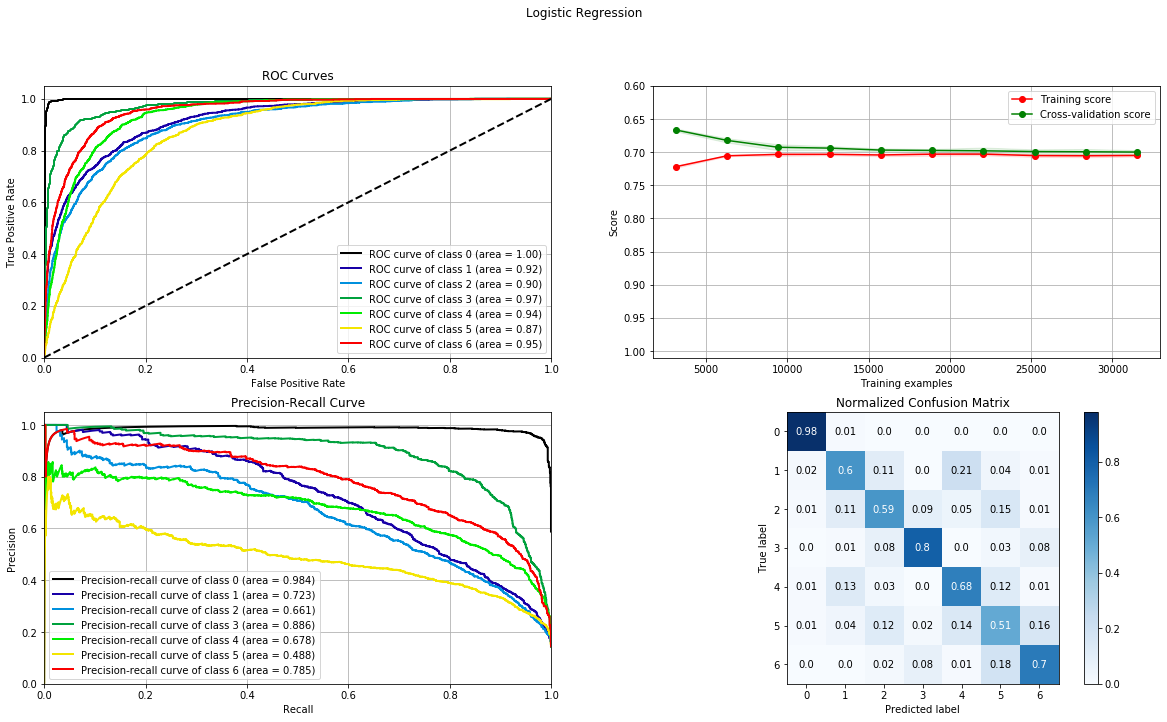

In [44]:
# Logistic Regression
lr = Class_Fit(clf = LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,10),
                              'random_state' : [0],
                              'class_weight' : ['balanced'],
                              'solver' : ['lbfgs'],
                              'multi_class' : ['ovr','multinomial'],
                              'max_iter' : [2000,4000, 5000]
                             }], Kfold = 5)
lr.grid_fit(X_train, y_train)
lr.grid_predict(X_test, y_test)

g = plot_model_curves(lr.grid.best_estimator_, "Logistic Regression", 
                        X_train, y_train, X_test, y_test, ylim = [1.01, 0.6], cv = 5, 
                        train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## Decision Tree

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:   28.2s
[Parallel(n_jobs=11)]: Done  50 out of  50 | elapsed:   40.9s finished


Best Estimator DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1411
           1       0.93      0.90      0.92      1387
           2       0.96      0.95      0.96      1423
           3       0.99      0.98      0.98      1394
           4       0.91      0.94      0.92      1411
           5       0.93      0.96      0.94      1408
           6       0.98      0.96      0.97      1413

    accuracy                           0.96      9847
   macro avg       0.96      0.95      0.96      9847
weighted avg    

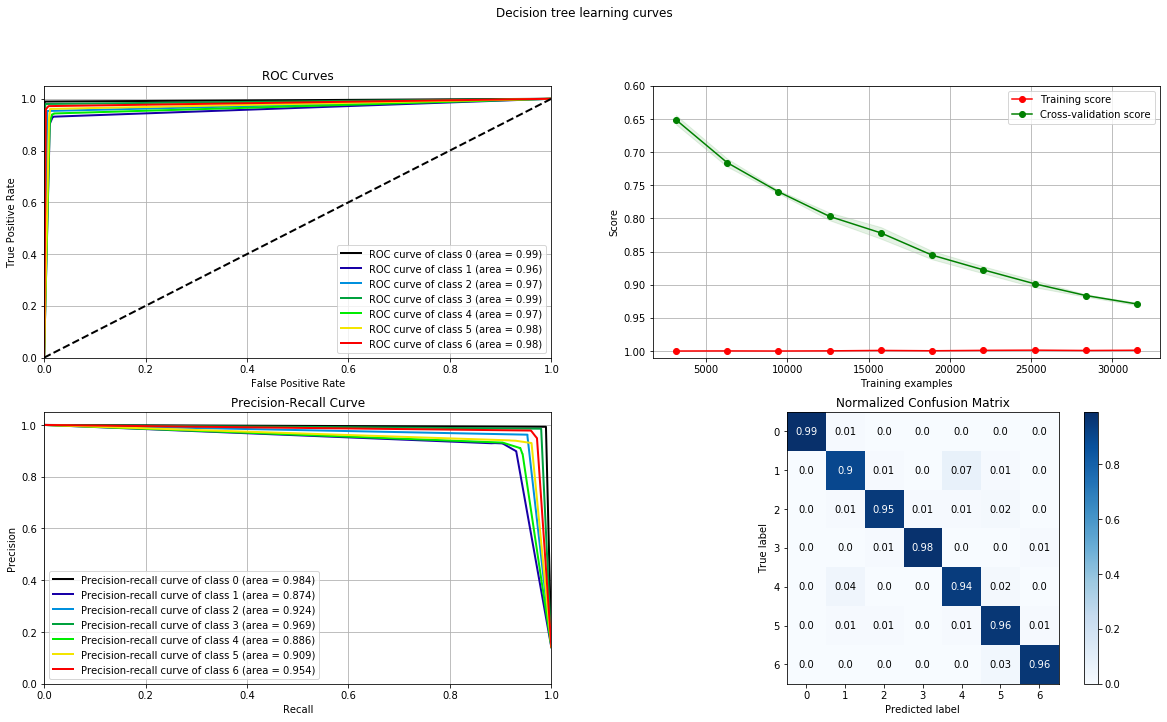

In [45]:
# Decision Tree
tr = Class_Fit(clf = DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'],
                             'max_depth' : [5, 10, 15, 20, 25],
                             'random_state' : [0]
                             }], Kfold = 5)
tr.grid_fit(X_train, y_train)
tr.grid_predict(X_test, y_test)
g = plot_model_curves(tr.grid.best_estimator_, "Decision tree learning curves", 
                        X_train, y_train, X_test, y_test, ylim = [1.01, 0.6], cv = 5, 
                        train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])



## Random Forest

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed:  1.7min
[Parallel(n_jobs=11)]: Done  50 out of  50 | elapsed:  2.8min finished


Best Estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1411
           1       0.97      0.97      0.97      1387
           2       0.98      0.99      0.98      1423
           3       1.00      0.99      0.99      1394
           4       0.97      0.97      0.97      1411
           5       0.98      0.98      0.98      1408
           6       0.99      0.99      0.99      1413

    accuracy                        

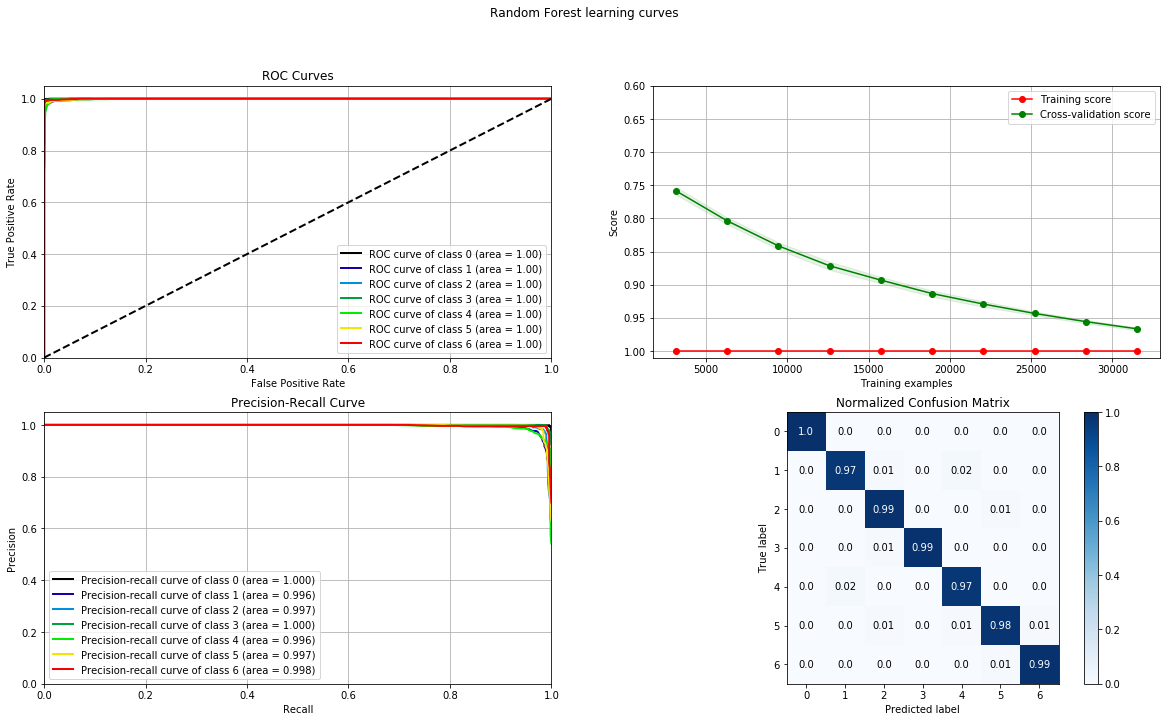

In [46]:
#  Random Forest
rf = Class_Fit(clf = RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 
              'n_estimators' : [20, 40, 60, 80, 100],
              'random_state' : [0],
              'verbose' : [0]}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X_train, y_train)
rf.grid_predict(X_test, y_test)
g = plot_model_curves(rf.grid.best_estimator_, "Random Forest learning curves", 
                        X_train, y_train, X_test, y_test, ylim = [1.01, 0.6], cv = 5, 
                        train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])


## Gradient Boosting Trees

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  28 tasks      | elapsed: 13.9min
[Parallel(n_jobs=11)]: Done  50 out of  50 | elapsed: 28.8min finished


Best Estimator GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1411
           1       0.81      0.70      0.75      1387
           2       0.75      0.74      0.74      1423
           3       0.86      0.89      0.87      1394
           4     

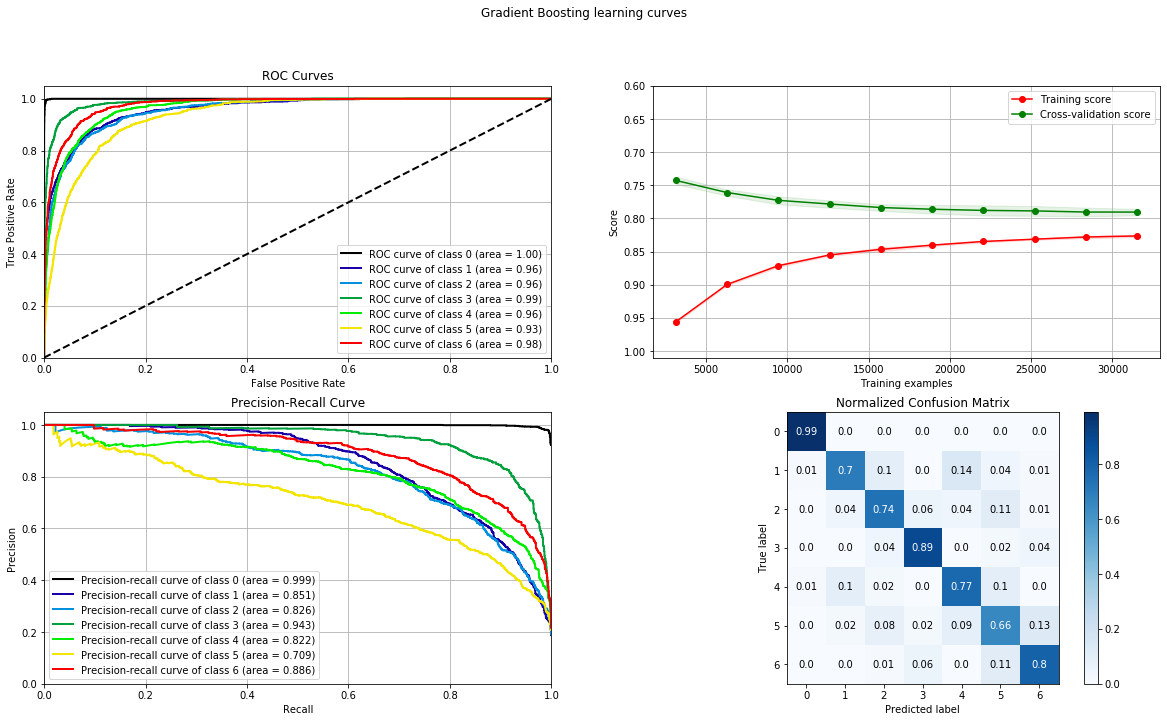

In [47]:
# Gradient Boost
gb = Class_Fit(clf = GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
              'random_state' : [0],
              'verbose' : [0]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X_train, y_train)
gb.grid_predict(X_test, y_test)
g = plot_model_curves(gb.grid.best_estimator_, "Gradient Boosting learning curves", 
                        X_train, y_train, X_test, y_test, ylim = [1.01, 0.6], cv = 5, 
                        train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## Neural Network (MLP)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  35 out of  35 | elapsed: 35.4min finished


Best Estimator MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=4000, learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Classification Report :
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1411
           1       0.96      0.93      0.94      1387
           2       0.96      0.95      0.96      1423
           3       0.98      0.98      0.98      1394
           4       0.93      0.96      0.95      1411
           5       0.93      0.95      0.94      1408
           6       0.97      0.96      0.96      1413

    accuracy                           0

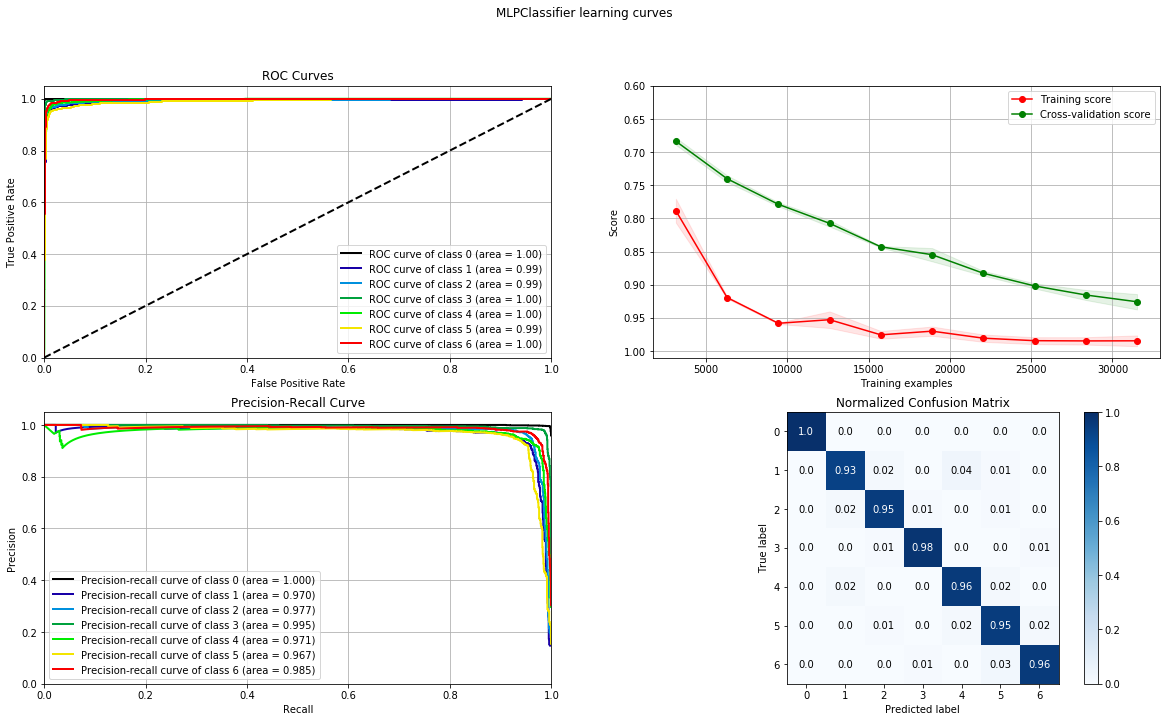

In [48]:
# MLPClassifier
nn = Class_Fit(clf = MLPClassifier)
param_grid = {'hidden_layer_sizes' : [10, 100, 200, 1000, 2000, 3000, 4000],
              'random_state' : [0],
              'verbose' : [0],
             'early_stopping' : [True]}
nn.grid_search(parameters = param_grid, Kfold = 5)
nn.grid_fit(X_train, y_train)
nn.grid_predict(X_test, y_test)
g = plot_model_curves(nn.grid.best_estimator_, "MLPClassifier learning curves", 
                        X_train, y_train, X_test, y_test, ylim = [1.01, 0.6], cv = 5, 
                        train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## Gaussian Naive Bayes

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of   5 | elapsed:    2.8s remaining:    4.2s
[Parallel(n_jobs=11)]: Done   5 out of   5 | elapsed:    2.8s finished


Best Estimator GaussianNB(priors=None, var_smoothing=1e-09)
Classification Report :
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1411
           1       0.31      0.32      0.32      1387
           2       0.35      0.33      0.34      1423
           3       0.91      0.24      0.37      1394
           4       0.36      0.87      0.51      1411
           5       0.19      0.13      0.16      1408
           6       0.58      0.36      0.45      1413

    accuracy                           0.46      9847
   macro avg       0.52      0.46      0.44      9847
weighted avg       0.52      0.46      0.44      9847



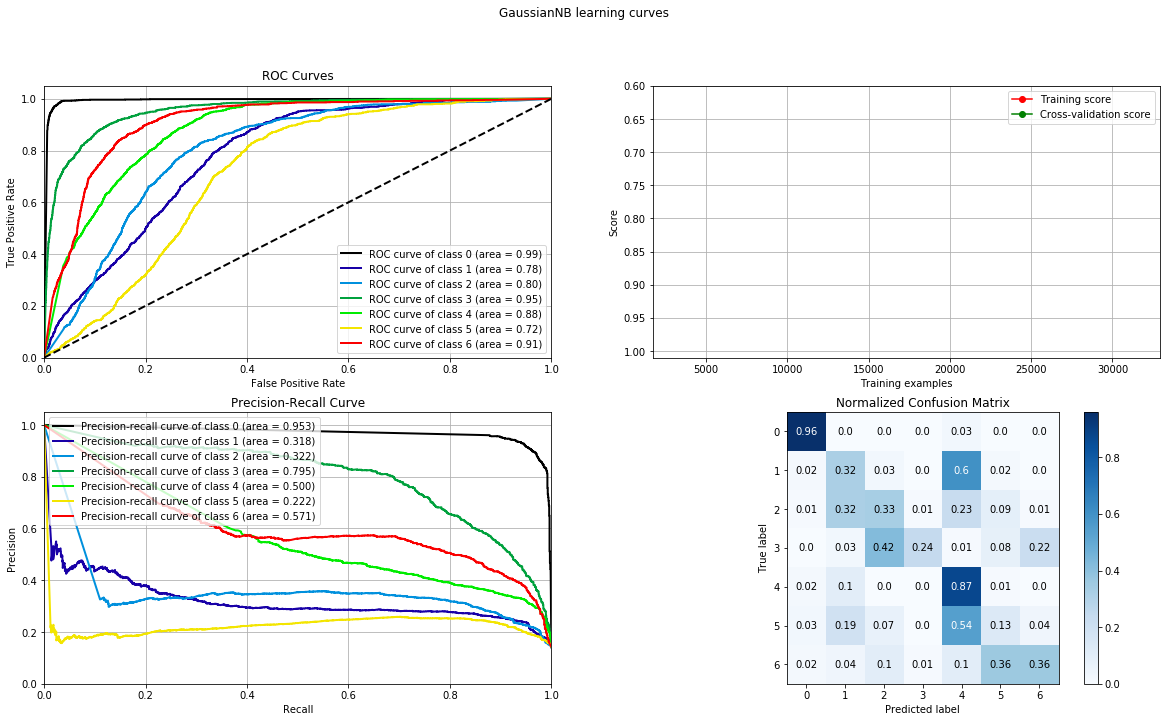

In [49]:
# GaussianNB
NB = Class_Fit(clf = GaussianNB)
param_grid = {}
NB.grid_search(parameters = param_grid, Kfold = 5)
NB.grid_fit(X_train, y_train)
NB.grid_predict(X_test, y_test)
g = plot_model_curves(NB.grid.best_estimator_, "GaussianNB learning curves", 
                      X_train, y_train, X_test, y_test, ylim = [1.01, 0.6], cv = 5, 
                      train_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

## Classification Results

In [50]:
classifier_results = [
    {'Model Type':'Linear','Classifier':'Logistic Regression','Label':'lr', 'Model':lr},
    {'Model Type':'Tree','Classifier':'Decision Tree','Label':'tr', 'Model':tr},
    {'Model Type':'Tree','Classifier':'Random Forest','Label':'rf', 'Model':rf},
    {'Model Type':'Tree','Classifier':'Gradient Boosting','Label':'gb', 'Model':gb},
    {'Model Type':'Neural Network','Classifier':'Multi-layer Perceptron','Label':'nn', 'Model':nn},
    {'Model Type':'Probabilistic','Classifier':'Gaussian Naive Bayes','Label':'NB', 'Model':NB}
]

clf_res = pd.DataFrame(classifier_results)
clf_res = clf_res[['Model Type','Classifier', 'Label', 'Model']]
clf_res['Recall'] = clf_res['Model'].apply(lambda x : recall_score(y_validation, x.grid.best_estimator_.predict(X_validation), average='weighted'))
clf_res['F1_Score'] = clf_res['Model'].apply(lambda x : f1_score(y_validation, x.grid.best_estimator_.predict(X_validation), average='weighted'))
clf_res['Accuracy'] = clf_res['Model'].apply(lambda x : accuracy_score(y_validation, x.grid.best_estimator_.predict(X_validation)))
clf_res.drop(['Model'], axis=1,inplace=True)
clf_res

,Model Type,Classifier,Label,Recall,F1_Score,Accuracy
0,Linear,Logistic Regression,lr,0.694695,0.694833,0.694695
1,Tree,Decision Tree,tr,0.955155,0.955232,0.955155
2,Tree,Random Forest,rf,0.983264,0.983253,0.983264
3,Tree,Gradient Boosting,gb,0.798359,0.798521,0.798359
4,Neural Network,Multi-layer Perceptron,nn,0.959867,0.959919,0.959867
5,Probabilistic,Gaussian Naive Bayes,NB,0.455927,0.436871,0.455927


## Mega-Estimator

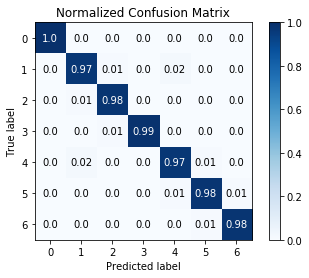

In [62]:
estimatorEnsemble = [
#     ('gb', GradientBoostingClassifier(**gb.grid.best_params_)),
                     ('rf', RandomForestClassifier(**rf.grid.best_params_)),
                     ('tr', DecisionTreeClassifier(**tr.grid.best_params_)),
                     ('nn', MLPClassifier(**nn.grid.best_params_))
                    ]

votingC = VotingClassifier(estimators=estimatorEnsemble, voting='soft')
votingC = votingC.fit(X_train, y_train)
skplt.metrics.plot_confusion_matrix(y_test, votingC.predict(X_test), normalize=True)
plt.show()

In [63]:
print(classification_report(y_test, votingC.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1411
           1       0.97      0.97      0.97      1387
           2       0.98      0.98      0.98      1423
           3       0.99      0.99      0.99      1394
           4       0.97      0.97      0.97      1411
           5       0.98      0.98      0.98      1408
           6       0.99      0.98      0.99      1413

    accuracy                           0.98      9847
   macro avg       0.98      0.98      0.98      9847
weighted avg       0.98      0.98      0.98      9847



# Make submission predictions

In [65]:
df_submission = pd.read_pickle('../data/df_submission.pkl.gzip', compression='gzip')
print(df_submission.shape)
df_submission.head()

(20982, 17)


,trace_id,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_travel_sec,s_arrival_sample,source_origin_time,source_latitude,source_longitude,source_depth_km,snr_db_E,snr_db_N,snr_db_Z,E,N,Z
0,trace_500,37.85884,-121.99264,259.0,399.0,13.806000,892.0,2011-04-16 12:40:15.591,52.55610,-116.23017,1.50,31.299999,49.900002,27.0,"[-0.0, -0.00022036854, -0.0006564023, -0.00178...","[-0.0, -1.5555523e-05, -2.6436726e-05, -5.1018...","[-0.0, -6.6268326e-06, -5.566338e-07, 7.242038..."
1,trace_501,36.68011,-119.02282,1140.0,600.0,5.080000,2148.0,2011-03-12 15:54:01.040,36.57950,-149.94900,16.00,28.900000,25.799999,26.6,"[-0.0, -0.003910351, -0.0076862974, -0.0587444...","[0.0, 0.0111518, 0.031661604, 0.098408185, 0.1...","[-0.0, -0.019765988, -0.061188668, -0.15370083..."
2,trace_502,60.19520,-154.32010,96.0,500.0,11.440000,1764.0,2015-03-25 00:10:57.680,37.66467,-117.30250,81.18,35.299999,26.900000,19.9,"[38.845078, 41.64532, 39.854225, 33.39964, 23....","[-42.89445, -27.585876, -12.321886, 2.3429925,...","[-21.905762, -5.8183093, 14.36668, 30.567423, ..."
3,trace_503,35.92920,-120.51530,583.0,700.0,10.580000,1216.5,2018-04-21 13:34:42.190,54.22590,17.02430,14.11,35.599998,37.599998,24.4,"[-0.0, -0.00024849953, -9.589619e-05, -0.00362...","[0.0, 0.00030432147, 0.0017123658, 0.004246875...","[0.0, 0.00016073156, 0.0014357661, 0.00039703,..."
4,trace_504,36.19250,-117.66850,1859.9,900.0,17.969999,921.0,2014-10-29 06:26:22.730,37.02580,-116.25717,6.16,27.299999,27.700001,24.6,"[0.0, 0.00027774205, -0.00014372196, -0.002718...","[-0.0, -2.7009946e-05, 0.00095413084, 0.001883...","[0.0, 0.0003360864, 0.0004533975, 0.0011395814..."


In [54]:
# import sys, importlib
# importlib.reload(sys.modules['PreProcessing_v2'])

In [66]:
from PreProcessing_v2_02 import preprocess
X_submission = preprocess(df_submission)

Calculate rolling Avg
     Processing - Degree of rectiliniarity (polarization)
     Starting Trace-By-Trace feature processing
     Processing - Envelope Similarity
          Processing Spectral Centroid
          RMS of frequency amplitude
          Maximum power of frequency amplitude
          Dominant frequency
          Processing Spectral Centroid
          RMS of frequency amplitude
          Maximum power of frequency amplitude
          Dominant frequency
          Processing Spectral Centroid
          RMS of frequency amplitude
          Maximum power of frequency amplitude
          Dominant frequency
          Processing Spectral Centroid
          RMS of frequency amplitude
          Maximum power of frequency amplitude
          Dominant frequency
          Processing Spectral Centroid
          RMS of frequency amplitude
          Maximum power of frequency amplitude
          Dominant frequency
          Processing Spectral Centroid
          RMS of frequency amplitud

In [67]:
X_submission.head()

,trace_id,spectral_centroid_E,spectral_centroid_N,spectral_centroid_Z,spectral_centroid_E_MA250,spectral_centroid_N_MA250,spectral_centroid_Z_MA250,spectral_centroid_E_MA1000,spectral_centroid_N_MA1000,spectral_centroid_Z_MA1000,...,E_env_sim_shallow_max,E_env_sim_shallow_mean,N_env_sim_deep_max,N_env_sim_deep_mean,N_env_sim_shallow_max,N_env_sim_shallow_mean,Z_env_sim_deep_max,Z_env_sim_deep_mean,Z_env_sim_shallow_max,Z_env_sim_shallow_mean
0,trace_500,8779.532633,8632.585642,8783.861892,4066.084798,3688.491806,3789.831981,4058.526401,3749.704185,3811.700316,...,-16.425813,-156.416262,3.109011e+06,1529.537371,-25.829823,-221.078873,95062.655056,195.411141,-18.990732,-199.184925
1,trace_501,6288.391222,6349.196226,7059.646783,3830.233225,3781.068034,3879.795876,3870.839581,3969.824292,3927.156141,...,-805.907772,-8586.215293,4.201186e+05,9091.150436,-669.413114,-8694.098126,780264.211711,8983.097201,-865.333890,-8971.955036
2,trace_502,1999.624595,2173.585480,2750.306284,1336.098999,1583.827881,2027.764087,1361.785442,1681.833407,2064.951852,...,-268.666137,-1878.368347,8.278550e+04,1654.280293,-106.312684,-605.666080,252093.399273,4596.306529,-651.432064,-4785.970986
3,trace_503,3103.101677,3146.113078,3823.042140,1687.279018,1907.143250,1757.977606,1702.963947,1899.423367,1744.579092,...,-2794.565284,-29013.084358,3.337719e+06,35190.338409,-3609.806066,-38945.102593,631260.909045,12574.041685,-3223.034832,-29481.823110
4,trace_504,7003.142487,5547.892532,7226.740676,3879.293945,3049.681653,3640.209340,3678.658565,3220.622434,3522.768892,...,-3676.156975,-20403.335457,1.054934e+06,12652.736936,-3223.476084,-21874.827601,412122.095240,10236.804104,-2813.923710,-15840.028938


In [68]:
X_submission =  ss.transform(X_submission.drop('trace_id',axis=1))

In [69]:
y_submission = votingC.predict(X_submission)
y_submission

array([0, 4, 5, ..., 4, 4, 3])

In [70]:
df_result = pd.DataFrame({'trace_id' : df_submission['trace_id'], 'submission' : y_submission})

In [71]:
df_result.to_csv('./99_ML_v2_02_Augment.csv',index=False)